### Position velocity diagram

### Import packages

In [6]:
import matplotlib
#matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
from astropy.io import fits 
import numpy as np  
import aplpy 
from spectral_cube import SpectralCube 
from matplotlib import lines
from astropy import wcs
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import SkyCoord
import os
import sys
from pvextractor.gui import PVSlicer 
from pvextractor import extract_pv_slice
from pvextractor.geometry import Path
import matplotlib.ticker as ticker

### Previous setup

In [7]:
writechan = False ## CHOOSE WHETHER TO WRITE IMAGE TO A FILE (True), OR DISPLAY DIRECTLY (False). #MOD
source=45 
vc=8.0*u.km/u.s

### Data file

In [8]:
filename='/home/juan/Desktop/Research/Data2.0/Serpens/Serpens_concat_c18o_cube.fits'

In [9]:
outname='pv_testS'+str(source)+'.eps'

### Map setup

In [10]:
cube0 = SpectralCube.read(filename)
ch0='' #MOD
chf='' #MOD
if ch0 != '' and chf !='': 
  cube = cube0.subcube(zlo=ch0,zhi=chf)
else: 
  cube=cube0
  ch0 = 0
  chf = cube.header['NAXIS3']

/home/juan/anaconda3/envs/old_env/lib/python2.7/site-packages/spectral_cube/spectral_cube.py:238: UserWarning: radio_beam is not installed. No beam can be created.
  warnings.warn("radio_beam is not installed. No beam "
/home/juan/anaconda3/envs/old_env/lib/python2.7/site-packages/spectral_cube/spectral_cube.py:246: UserWarning: Could not parse beam information from header.  Exception was: UnboundLocalError("local variable 'Beam' referenced before assignment",)
  "  Exception was: {0}".format(ex.__repr__()))


### Create figure

In [11]:
fig3 = plt.figure(figsize=(9,6)) #MOD
fig3.clf() 

<Figure size 648x432 with 0 Axes>

### Source coordinates

In [12]:
filenametxt='/home/juan/Desktop/Research/Data/sourcecoordinates.txt'
ra,dec = np.loadtxt(filenametxt,unpack=True,usecols=(0,1),dtype='S')

In [13]:
Ra=[]
Dec=[]
for i in range(len(ra)):
    Ra.append(ra[i].decode("utf-8"))
for i in range(len(dec)):
    Dec.append(dec[i].decode("utf-8"))

In [14]:
coord=SkyCoord(Ra,Dec,frame='icrs',unit=(u.hourangle,u.deg)) 
c = SkyCoord(coord[source-1].ra,coord[source-1].dec, frame='icrs',unit=(u.hourangle,u.deg))

### Optional

In [15]:
def standard_setup(sp): 
  sp.set_frame_color('black')
  sp.set_tick_labels_font(size='14')
  sp.set_axis_labels_font(size='16')
  sp.set_tick_labels_format(xformat='hh:mm:ss',yformat='dd:mm:ss') 
  sp.set_tick_color('black')
  sp.set_system_latex(True) #use latex math symbols in plots
def pv_setup(sp):
  sp.set_frame_color('black')
  sp.set_tick_labels_font(size='14')
  sp.set_axis_labels_font(size='16')
  #sp.set_tick_labels_format(xformat='mm:ss',yformat='dd:mm:ss') 
  sp.set_tick_color('black')
  sp.set_system_latex(True)

### Locate source

In [16]:
RAcoord=c.ra
Deccoord=c.dec
xcoord=[0,cube.shape[2]] 
ycoord=[0,cube.shape[1]]
x_w,y_w=[RAcoord.value],[Deccoord.value]
dchan=1 #0.5 to shorten interval
amp=5

### Source PV info

### We extract the cut info from 2D fitting performed in CASA. That step has to be done again for the new data.

In [17]:
file2dfit='/home/juan/Desktop/Research/Data2.0/2DFit/'+str(source)+'/2DGssfit'+str(source)+'Log.txt'
file1=open(file2dfit,'r')
i=1
for line in file1:
	if i==27:
		line1=line
	if i==29:
		line2=line
	i+=1
file1.close()
for j in range(len(line1)):
	if line1[j]==':':
		k=j+1
		majax1=''
		while line1[k]!='+':
			majax1+=line1[k]
			k+=1
for j in range(len(line2)):
	if line2[j]==':':
		k=j+1
		angle1=''
		while line2[k]!='+':
			angle1+=line2[k]
			k+=1
dchan=1 #0.5 to shorten interval
amp=5
majorax=amp*float(majax1.strip())

### Panel (b): PV Plot

In [18]:
panels=[[0.005,0.5,0.326,0.48],[0.336,0.5,0.326,0.48],[0.667,0.5,0.326,0.48],[0.005,0.01,0.326,0.48],[0.336,0.01,0.326,0.48],[0.667,0.01,0.326,0.48]]
angles=[0.0,30.0,60.0,float(angle1.strip()),110.0,140.0]

for i in range(6):
	angle=angles[i]
	majorax=amp*float(majax1.strip())

	#PV-CUT:
halflength = majorax/2.*u.arcsec  #MOD
pa = angle*u.deg #Deg: degrees away from vertical.
avnumb=6 #number of pixels to average perpendicular to pv-cut #MOD
inter = 1*u.arcsec #interval you want the arcsec to be marked on #MOD

# Calculate the x,y coordinates on either end of the PV cut
upperx = RAcoord+halflength.to(u.deg)*np.sin(pa.to(u.rad))
lowerx = RAcoord-halflength.to(u.deg)*np.sin(pa.to(u.rad))
uppery = Deccoord+halflength.to(u.deg)*np.cos(pa.to(u.rad))
lowery = Deccoord-halflength.to(u.deg)*np.cos(pa.to(u.rad))
endpoints_deg = np.array([[upperx.value,uppery.value],[lowerx.value,lowery.value]]) 

### Panel (a): Moment 0 map

/home/juan/anaconda3/envs/old_env/lib/python2.7/site-packages/spectral_cube/masks.py:185: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = data[view].astype(dt)
/home/juan/anaconda3/envs/old_env/lib/python2.7/site-packages/spectral_cube/masks.py:503: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self._function(self._data[view])
/home/juan/anaconda3/envs/old_env/lib/python2.7/site-packages/aplpy/labels.py:432: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being

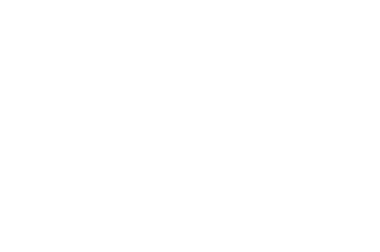

In [19]:
## FIRST MAKE MOMENT MAP:
moment_0 = cube0.moment(order=0)
## NEXT PLOT (next to the PV plot):
f2 = aplpy.FITSFigure(moment_0.hdu,dimensions=[0,1],figure=fig3,subplot=(panels[i]))
standard_setup(f2) 
#f2._ax1.yaxis.labelpad = -20 ## Move label closer to figure #MOD
mom0_vmin = np.nanmin(moment_0).value*0.4 #modify multiplicative factor to make #MOD better contrast
mom0_vmax = np.nanmax(moment_0).value*0.6 #Shorten colorscale to make it more sensible for a higher number of pixels. #MOD
f2.show_grayscale(vmin=mom0_vmin,vmax=mom0_vmax,invert=True)
xx=np.abs(cube0.header['NAXIS1']*cube0.header['cdelt1'])
yy=np.abs(cube0.header['NAXIS2']*cube0.header['cdelt2'])
mapwidth=5.*u.arcsec #MOD
mapheight=5.*u.arcsec #MOD
f2.recenter(RAcoord,Deccoord,width=mapwidth.to(u.deg).value,height=mapheight.to(u.deg).value)
f2.show_markers(RAcoord, Deccoord,marker="*",c='None',edgecolors="magenta",s=300,linewidths=2.0)#MOD
plt.axis('off')
f2.add_label(0.15,0.9,str(pa.value)+' deg',relative=True,color='red',size='large')
#### TO SHOW PV CUT
f2.show_lines([endpoints_deg.T],color='DarkMagenta',linewidths=2.0,linestyle='-')
#BEAMSIZE
'''bmaj=1.043*u.arcsec.to(u.deg) #MOD
bmin=0.7046*u.arcsec.to(u.deg) #MOD
bpa=76.299 #MOD
f2.show_beam(major=bmaj,minor=bmin,angle=bpa,fill=True,color='DeepSkyBlue') #MOD
f2.add_label(0.7, 0.93, '(a) C18O map', relative=True, color="Black", size=20) #MOD'''
#MODIFY AXES:
'''F4.refresh() 
print([x.get_text()[1:-1] for x in F4._ax1.get_yticklabels()]) 
xlim=F4._ax1.get_xlim() 
ylim=F4._ax1.get_ylim()
xlim_lo = minvel 
xlim_hi = maxvel
ylim_lo=(ylim[0])*pv.header['CDELT1']+pv.header['CRVAL1']-pv.header['CDELT1']
ylim_hi=(ylim[1])*pv.header['CDELT1']+pv.header['CRVAL1']-pv.header['CDELT1']
npix = round(halflength.to(u.deg) / (cube.header['cdelt2']*u.deg))
inter_px = inter.to(u.deg).value/(ylim_hi-ylim_lo)*(ylim[1]-ylim[0])
ntick = (int((ylim_hi-ylim_lo)/inter.to(u.deg).value)+2) 
print([x.get_text() for x in F4._ax1.get_yticklabels()])
F4.refresh() 
F4._ax1.yaxis.set_major_locator(ticker.MultipleLocator(inter_px)) 
F4._ax1.yaxis.set_minor_locator(ticker.MultipleLocator(inter_px/inter.value)) 
newticks = np.arange(0,inter.value*ntick,inter.value)-halflength.value 
F4._ax1.set_yticklabels(newticks)
F4.refresh()
print([x.get_text()[:-2] for x in F4._ax1.get_yticklabels()])
F4._ax1.set_xticklabels([str(float(x.get_text()[:])/1000.*dchan)[:-2] for x in F4._ax1.get_xticklabels()])
F4._ax1.set_yticklabels([x.get_text()[:] for x in F4._ax1.get_yticklabels()])##NOTE## Here edit the indexing of x.get_text()[:-2]. #with [:-2] we achieve to do '12.0 -> '12'
F4._ax1.set_ylabel('Offset (arcsec)') 
F4._ax1.set_xlabel("$V_{LSR} (\mathrm{km\ s}^{-1})$")
print([x.get_text() for x in F4._ax1.get_yticklabels()])
F4.refresh()
F4._ax2.yaxis.set_major_locator(ticker.MultipleLocator(inter_px)) 
F4._ax2.yaxis.set_minor_locator(ticker.MultipleLocator(inter_px/inter.value))
F4._ax1.yaxis.labelpad = -9 #Edit to modify spacing #MOD'''

'''
################################
## FINAL ANNOTATIONS
################################
# HORIZONTAL LINE TO SHOW resolution in PV Plot. 
res_elem = 0.15*u.arcsec ##?## Where do I get this?? #resolution element, or beam size #MOD
x1_res=res_elem.to(u.deg).value 
x2_res=x1_res+res_elem.to(u.deg).value 
y1_res=pvcube.spectral_axis.min().value
y2_res=pvcube.spectral_axis.max().value 
 

 
# Set up a second Axis on top of pv plot, to show annotations (if necessary) ##?## invisible axes just to make annotations
ax2 = fig3.add_axes(rightpanel) 
ax2.set_xlim(xlim_lo,xlim_hi)
ax2.set_ylim(ylim_lo,ylim_hi)
 
ax2.set_axis_off()
 
# VERTICAL (dashed) LINE TO SHOW v_c in PV Plot
hx1 = 0.
hx2 = 2.*halflength.to(u.deg).value
hy1 = vc.to(u.m/u.s).value
ax2.vlines(hy1,hx1,hx2,colors='green',linestyles='dashed',label='$v_c$',zorder='3',lw=2) ##?## ##JP## I am getting vertical line shifted #MOD
ax2.annotate('$v_c$',xy=(hy1,x1_res*2.0),xycoords='data',color='green',size='16')
 
# HORIZONTAL (dashed) LINE TO SHOW star position in PV Plot. Separate position to left and right from the source along the position line. 
hx3 = xlim_lo
hx4 = xlim_hi
hy3 = halflength.to(u.deg).value
#### NOTE, You have to move these around a bit depending on your target. #MOD
ax2.hlines(hy3,hx3,hx4,colors='magenta',linestyles='dashed',label='protostar',zorder='3',lw=2)
ax2.annotate('protostar',xy=(xlim_hi,hy3-2*res_elem.to(u.deg).value),xycoords='data',color='magenta',size='20',verticalalignment='top')
ax2.annotate('(b) CO, \n PV diag.',xy=(xlim_hi,hy3+8*res_elem.to(u.deg).value),xycoords='data',color='Black',size='20',verticalalignment='top')'''

##SHOW/SAVE FIGURE:
#plt.show()
if writechan: 
  plt.savefig(outname)
#if not writechan:
  #print 'print to screen'
  #fig3.show() 
#plt.close(fig3)

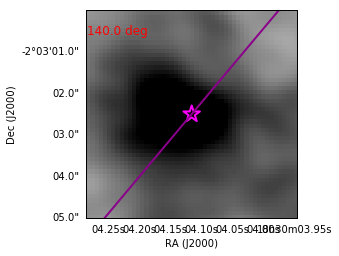

In [20]:
fig3